In [18]:
import torch
import math
from typing import Tuple
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES


In [19]:
class GVAE(nn.Module):
    def __init__(self, device : torch.device):
        super().__init__()
        self.graph_emb_dim = 512
        self.device = device

        self.encoder = TransformerEncoder(node_dim = NODE_FEATURE_DIMENSION, 
                                          edge_dim = EDGE_FEATURE_DIMENSION, 
                                          graph_emb_dim = self.graph_emb_dim, 
                                          num_tf_layers = 2, 
                                          num_heads = 4,
                                          device = self.device
                                         )
        
        self.decoder = TransformerDecoder(node_dim = NODE_FEATURE_DIMENSION, 
                                          edge_dim = EDGE_FEATURE_DIMENSION, 
                                          graph_emb_dim = self.graph_emb_dim,
                                          num_tf_layers = 2,
                                          num_heads = 4, 
                                          device = self.device
                                         )
    
    def forward(self, nodes : Tensor, edges : Tensor):
        means, logvars = self.encoder(nodes, edges)
        latents = self.sample_latent(means, torch.exp(0.5 * logvars))
        pred_nodes, pred_edges = self.decoder(latents)

        return pred_nodes, pred_edges, means, logvars
    
    def sample_latent(self, mean : Tensor, standard_deviation : Tensor):
        epsilon = torch.randn(size=mean.size(), device = self.device)
        latents = mean + standard_deviation * epsilon
        return latents
    
    def sample_graph(self) -> Tuple[Tensor, Tensor]:
        latent = torch.randn(size = (self.graph_emb_dim,), device = self.device)
        nodes, edges = self.decoder(latent)
        nodes = nodes.detach()
        edges = edges.detach()

        nodes[:,:,1:6] = F.softmax(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes
        
        # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
        edges[:,:,:,0:4] = F.softmax(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
        edges[:,:,:,4:8] = F.softmax(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
        edges[:,:,:,8: ] = F.softmax(edges[:,:,:,8: ], dim = 3) # Softmax for edge type
        return torch.squeeze(nodes), torch.squeeze(edges)

class TransformerEncoder(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers: int, num_heads : int, device : torch.device): # perm_emb_dim: int,
        super().__init__()
        self.node_dim = node_dim # Number of features per node
        self.edge_dim = edge_dim # Number of features per edge
        self.graph_emb_dim = graph_emb_dim # Size of graph embedding vector
        # self.perm_emb_dim = perm_emb_dim # Size of permutation embedding vector

        self.mlp_node_hidden_dim = 64
        self.mlp_edge_hidden_dim = 32

        self.tf_node_hidden_dim = 64
        self.tf_edge_hidden_dim = 32

        self.num_tf_layers = num_tf_layers
        self.num_heads = num_heads

        self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.mlp_node_hidden_dim, device = device),
                                          nn.LeakyReLU(),
                                          nn.Linear(in_features = self.mlp_node_hidden_dim, out_features = self.tf_node_hidden_dim, device = device),
                                          nn.LeakyReLU()
                                         )

        self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.mlp_edge_hidden_dim, device = device),
                                          nn.LeakyReLU(),
                                          nn.Linear(in_features = self.mlp_edge_hidden_dim, out_features = self.tf_edge_hidden_dim, device = device),
                                          nn.LeakyReLU()
                                         )
        
        self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                         in_node_dim = self.tf_node_hidden_dim, 
                                                         out_node_dim = self.tf_node_hidden_dim,
                                                         in_edge_dim = self.tf_edge_hidden_dim,
                                                         out_edge_dim = self.tf_edge_hidden_dim, 
                                                         device = device
                                                        ) 
                                        for _ in range(self.num_tf_layers)])
        
        self.lin_edge = nn.Linear(in_features = self.tf_edge_hidden_dim, out_features = self.tf_node_hidden_dim, device = device)
        self.pna = PNA()

        self.mlp_mean = nn.Sequential(nn.Linear(in_features = 4 * self.tf_node_hidden_dim, out_features = self.tf_node_hidden_dim, device = device),
                                      nn.LeakyReLU(),
                                      nn.Linear(in_features = self.tf_node_hidden_dim, out_features = self.graph_emb_dim, device = device),
                                      nn.LeakyReLU()
                                     )
        
        self.mlp_logvar = nn.Sequential(nn.Linear(in_features = 4 * self.tf_node_hidden_dim, out_features = self.tf_node_hidden_dim, device = device),
                                        nn.LeakyReLU(),
                                        nn.Linear(in_features = self.tf_node_hidden_dim, out_features = self.graph_emb_dim, device = device),
                                        nn.LeakyReLU()
                                       )

    def forward(self, nodes : Tensor, edges : Tensor):
        nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x mlp_node_hidden_dim
        edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x mlp_edge_hidden_dim

        for layer in self.tf_layers:
            nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
        
        edges = self.lin_edge(edges) # batch_size x num_nodes x num_nodes x tf_node_hidden_dim

        nodes = self.pna(nodes, dim = (1))   # batch_size x (4 * tf_node_hidden_dim)
        edges = self.pna(edges, dim = (1,2)) # batch_size x (4 * tf_node_hidden_dim)

        graph_embs = nodes + edges # batch_size x (4 * tf_node_hidden_dim)

        means = self.mlp_mean(graph_embs)     # batch_size x graph_emb_dim
        logvars = self.mlp_logvar(graph_embs) # batch_size x graph_emb_dim

        return means, logvars     

class TransformerDecoder(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers : int, num_heads : int, device : torch.device):
        super().__init__()
        self.graph_emb_dim = graph_emb_dim

        self.mlp_in_node_dim = 32
        self.mlp_out_node_dim = 64
        self.mlp_in_edge_dim = 24
        self.mlp_out_edge_dim = 32

        self.tf_node_hidden_dim = 64
        self.tf_edge_hidden_dim = 32
        self.num_tf_layers = num_tf_layers
        self.num_heads = num_heads

        self.mlp_create_nodes = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = MAX_NUM_PRIMITIVES * self.mlp_in_node_dim, device = device),
                                              nn.LeakyReLU(),
                                              nn.Linear(in_features = MAX_NUM_PRIMITIVES * self.mlp_in_node_dim, out_features = MAX_NUM_PRIMITIVES * self.mlp_out_node_dim, device = device),
                                              nn.LeakyReLU()
                                             )
        
        self.mlp_create_edges = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, 
                                                        out_features = MAX_NUM_PRIMITIVES * MAX_NUM_PRIMITIVES * self.mlp_in_edge_dim, 
                                                        device = device
                                                       ),
                                              nn.LeakyReLU(),
                                              nn.Linear(in_features = MAX_NUM_PRIMITIVES * MAX_NUM_PRIMITIVES * self.mlp_in_edge_dim, 
                                                        out_features = MAX_NUM_PRIMITIVES * MAX_NUM_PRIMITIVES * self.mlp_out_edge_dim, 
                                                        device = device
                                                       ),
                                              nn.LeakyReLU()
                                             )

        self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                         in_node_dim = self.tf_node_hidden_dim, 
                                                         out_node_dim = self.tf_node_hidden_dim,
                                                         in_edge_dim = self.tf_edge_hidden_dim,
                                                         out_edge_dim = self.tf_edge_hidden_dim, 
                                                         device = device
                                                        ) 
                                        for _ in range(self.num_tf_layers)])

        self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.mlp_out_node_dim, out_features = self.mlp_out_node_dim, device = device),
                                           nn.LeakyReLU(),
                                           nn.Linear(in_features = self.mlp_out_node_dim, out_features = node_dim, device = device)
                                          )

        self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.mlp_out_edge_dim, out_features = self.mlp_out_edge_dim, device = device),
                                           nn.LeakyReLU(),
                                           nn.Linear(in_features = self.mlp_out_edge_dim, out_features = edge_dim, device = device)
                                          )

    def forward(self, latents):
        nodes = torch.reshape(input = self.mlp_create_nodes(latents), shape = (-1, MAX_NUM_PRIMITIVES, self.mlp_out_node_dim))                     # batch_size x num_nodes x mlp_node_out_dim
        edges = torch.reshape(input = self.mlp_create_edges(latents), shape = (-1, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, self.mlp_out_edge_dim)) # batch_size x num_nodes x num_nodes x mlp_edge_out_dim

        for layer in self.tf_layers:
            nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; # batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
        
        nodes = self.mlp_out_nodes(nodes) # batch_size x num_nodes x node_dim
        edges = self.mlp_out_edges(edges) # batch_size x num_nodes x num_nodes x edge_dim

        # sigmoid and softmax for nodes
        nodes[:,:,0] = F.sigmoid(nodes[:,:,0])  # Sigmoid for isConstructible
        # nodes[:,:,1:6] = F.softmax(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes
        
        # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
        # edges[:,:,:,0:4] = F.softmax(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
        # edges[:,:,:,4:8] = F.softmax(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
        # edges[:,:,:,8: ] = F.softmax(edges[:,:,:,8: ], dim = 3) # Softmax for edge type

        return nodes, edges

# Graph Transformer Layer outlined by DiGress Graph Diffusion
class TransformerLayer(nn.Module):
    def __init__(self, num_heads : int, in_node_dim : int, out_node_dim : int, in_edge_dim : int, out_edge_dim : int, device : torch.device):
        super().__init__()
        self.num_heads = num_heads
        self.in_node_dim = in_node_dim
        self.out_node_dim = out_node_dim
        self.in_edge_dim = in_edge_dim
        self.out_edge_dim = out_edge_dim

        self.attention_heads = nn.ModuleList([AttentionHead(in_node_dim = self.in_node_dim, 
                                                            out_node_dim = self.out_node_dim, 
                                                            in_edge_dim = self.in_edge_dim, 
                                                            device = device
                                                           )
                                              for _ in range(self.num_heads)])
        
        self.lin_nodes = nn.Linear(in_features = self.num_heads * self.out_node_dim, out_features = self.out_node_dim, device = device)
        self.lin_edges = nn.Linear(in_features = self.num_heads * self.out_node_dim, out_features = self.out_edge_dim, device = device)

        self.dropout_nodes = nn.Dropout(p = 0.1)
        self.dropout_edges = nn.Dropout(p = 0.1)
        self.lnorm1_nodes = nn.LayerNorm(normalized_shape = self.out_node_dim, device = device)
        self.lnorm1_edges = nn.LayerNorm(normalized_shape = self.out_edge_dim, device = device)

        self.mlp_dropout_nodes = nn.Sequential(nn.Linear(in_features = self.out_node_dim, out_features = self.out_node_dim, device = device),
                                               nn.LeakyReLU(),
                                               nn.Dropout(p = 0.1),
                                               nn.Linear(in_features = self.out_node_dim, out_features = self.out_node_dim, device = device),
                                               nn.Dropout(p = 0.1)
                                              )
        self.lnorm2_nodes = nn.LayerNorm(normalized_shape = self.out_node_dim, device = device)
        
        self.mlp_dropout_edges = nn.Sequential(nn.Linear(in_features = self.out_edge_dim, out_features = self.out_edge_dim, device = device),
                                               nn.LeakyReLU(),
                                               nn.Dropout(p = 0.1),
                                               nn.Linear(in_features = self.out_edge_dim, out_features = self.out_edge_dim, device = device),
                                               nn.Dropout(p = 0.1)
                                              )
        self.lnorm2_edges = nn.LayerNorm(normalized_shape = self.out_edge_dim, device = device)
        
    
    def forward(self, nodes : Tensor, edges : Tensor):
        # Collect the output of all attention heads ; *Note nodes and edges are NOT on different devices
        nodes_heads = torch.Tensor().to(nodes.device)
        edges_heads = torch.Tensor().to(edges.device)
        for attention_head in self.attention_heads:
            temp_nodes, temp_edges = attention_head(nodes, edges) # nodes = batch_size x num_nodes x out_node_dim; edges = batch_size x num_nodes x num_nodes x out_node_dim
            nodes_heads = torch.cat(tensors = (nodes_heads, temp_nodes), dim = 2)
            edges_heads = torch.cat(tensors = (edges_heads, temp_edges), dim = 3)
        # now nodes_heads = batch_size x num_nodes x (num_heads * out_node_dim)
        # now edges_heads = batch_size x num_nodes x num_nodes x (num_heads * out_node_dim)

        # Combine Attention Head Output
        new_nodes = self.lin_nodes(nodes_heads) # batch_size x num_nodes x out_node_dim
        new_edges = self.lin_edges(edges_heads) # batch_size x num_nodes x num_nodes x out_edge_dim

        # Dropout & Layer Norm
        temp_new_nodes = self.dropout_nodes(new_nodes)
        temp_new_edges = self.dropout_edges(new_edges)

        new_nodes = self.lnorm1_nodes(temp_new_nodes + new_nodes)
        new_edges = self.lnorm1_edges(temp_new_edges + new_edges)

        # Transform into output nodes and edges
        temp_new_nodes = self.mlp_dropout_nodes(new_nodes) # batch_size x num_nodes x out_node_dim
        temp_new_edges = self.mlp_dropout_edges(new_edges) # batch_size x num_nodes x num_nodes x out_edge_dim

        new_nodes = self.lnorm2_nodes(temp_new_nodes + new_nodes)
        new_edges = self.lnorm2_edges(temp_new_edges + new_edges)

        return new_nodes, new_edges

# Outer Product Attention Head
class AttentionHead(nn.Module):
    def __init__(self, in_node_dim : int, out_node_dim : int, in_edge_dim : int, device : torch.device):
        super().__init__()
        self.in_node_dim = in_node_dim
        self.out_node_dim = out_node_dim
        self.in_edge_dim = in_edge_dim

        self.lin_query = nn.Linear(in_features = self.in_node_dim, out_features = self.out_node_dim, device = device)
        self.lin_key = nn.Linear(in_features = self.in_node_dim, out_features = self.out_node_dim, device = device)
        self.lin_value = nn.Linear(in_features = self.in_node_dim, out_features = self.out_node_dim, device = device)

        self.edge_film = FiLM(self.in_edge_dim, self.out_node_dim, device = device)

    def forward(self, nodes : Tensor, edges : Tensor):
        queries = self.lin_query(nodes) # batch_size x num_nodes x out_node_dim
        keys = self.lin_key(nodes)      # batch_size x num_nodes x out_node_dim
        values = self.lin_value(nodes)  # batch_size x num_nodes x out_node_dim

        # Outer Product Attention -------
        queries = queries.unsqueeze(2)                                       # batch_size x num_nodes x 1 x out_node_dim (each element in batch is a column tensor where each element is a row? vector)
        keys = keys.unsqueeze(1)                                             # batch_size x 1 x num_nodes x out_node_dims (each element in batch is a row tensor where each element is a row? vector)
        attention = torch.mul(queries, keys) / math.sqrt(self.out_node_dim)  # batch_size x num_nodes x num_nodes x out_node_dim (each element in batch is a 2d tensor where each element is a row? vector)

        # Incorporate edge features into attention
        edge_attention = self.edge_film(edges, attention) # batch_size x num_nodes x num_nodes x out_node_dim (each element in batch is a 2d tensor, where each element in 2d tensor is a row? vector)

        # Normalize attention; Digress uses softmax to normalize but the original outer product attention paper uses tanh
        normalized_attention = torch.softmax(input = edge_attention, dim = 3) # element wise softmax, so every element vector is normalized

        # Weight node representations
        values = values.unsqueeze(1)                               # batch_size x 1 x num_nodes x out_node_dims
        weighted_values = torch.mul(normalized_attention, values)  # batch_size x num_nodes x num_nodes x out_node_dim
        weighted_values = torch.sum(weighted_values, dim = 2)      # batch_size x num_nodes x out_node_dim

        return weighted_values, edge_attention

# Feature-Wise Linear Modulation Layer
class FiLM(nn.Module):
    def __init__(self, a_feature_dim : int, b_feature_dim : int, device : torch.device):
        super().__init__()
        
        self.lin1 = nn.Linear(in_features = a_feature_dim, out_features = b_feature_dim, device = device)
        self.lin2 = nn.Linear(in_features = a_feature_dim, out_features = b_feature_dim, device = device)
    
    def forward(self, a : Tensor, b : Tensor):
        mul = self.lin1(a)
        add = self.lin2(a)

        # For vanilla FiLM you are only supposed to do mul * b + add
        # I assume the additional '+ b' is there as a skip connection
        return torch.mul(mul, b) + add + b

# Principal Neighbourhood Aggregation Layer
class PNA(nn.Module):
    def __init__(self):
        super().__init__()
        # self.mean_aggr = MeanAggregation()
        # self.max_aggr = MaxAggregation()
        # self.min_aggr = MinAggregation()
        # self.std_aggr = StdAggregation()
    
    def forward(self, input : Tensor, dim):
        # find the biggest element in dim
        mean = torch.mean(input, dim)
        max = torch.amax(input, dim)
        min = torch.amin(input, dim)
        stdev = torch.std(input, dim) # Standard Deviation

        return torch.cat(tensors = (mean, max, min, stdev), dim = 1)

Sketch(n_entities=12, n_constraints=19)
Sketch(n_entities=24, n_constraints=576)


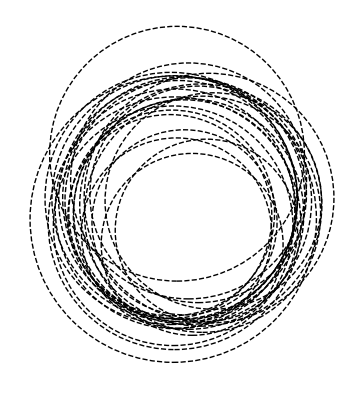

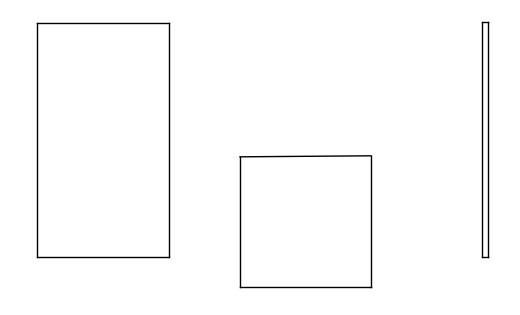

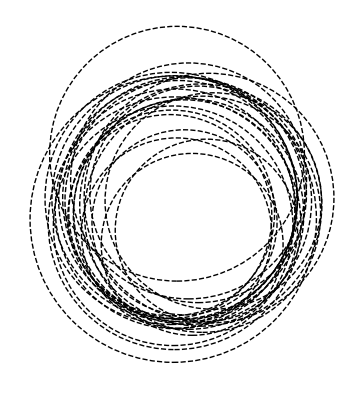

In [15]:
# model = GVAE(device)
# dataset = SketchDataset(root="data/")
# dataset.len()

# nodes, edges, node_params_mask = dataset[0]


# s2 = dataset.preds_to_sketch(nodes, edges)

# datalib.render_sketch(s2)

# print(s2)

# # batch_size = 64
# # dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
# # learning_rate = 1e-2
# # epochs = 4
# # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# # model.train()
# # for batch, (nodes, edges, node_params_mask) in enumerate(dataloader):
# #     optimizer.zero_grad()
    
# #     target_nodes = nodes.to(device)
# #     target_edges = edges.to(device)
# #     node_params_mask = node_params_mask.to(device)

# #     pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

# #     loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

# #     loss.backward()
# #     optimizer.step()

# #     print(f"loss: {loss.item()}")


# model.eval()
# nodes, edges = model.sample_graph()
# sketch = SketchDataset.preds_to_sketch(nodes.cpu(), edges.cpu())
# print(sketch)
# datalib.render_sketch(sketch)